# Demonstration of arb_qubit_system

> @author: Jiheng Duan

The `arb_qubit_system` class for setting up a qubit system with any desired simulation by directly writing in the matrix element of the Hamiltonian. It is more fundamental and can simulate arbitrary type of superconducting qubit (e.g., fluxonium).  

### Required Import

**The following thing must be import.**

In the current folder, the system structure are based on file `~\System\arb_qubit_system.py`. For using transmon system structure, please move to the demonstration file under `~\Tutorial\`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
# This on is a path correcting code, which is used to find the path of qusim.
sys.path.append('../..')

import qusim.System.arb_qubit_system as aqs
# Some useful tools
import qusim.Instruments.tools as tools

### Optional import

**The following import are optional**

In [2]:
# Some intrinsic plotting function
import qusim.DataPlot.plot_lib as pl

# Print the full output
np.set_printoptions(threshold=sys.maxsize)

# auto reload
%load_ext autoreload
%autoreload 2 

# variable name -> string
def var_name2str(variable):
    def nested_var_name2str(value):
        if isinstance(value, list):
            return [nested_var_name2str(item) for item in value]
        else:
            for name in globals():
                if eval(name) == value:
                    return name
            return str(value)
    return nested_var_name2str(variable)

## The Matrix Formulism

Assume The System Hamiltonian for a $N$ qubit system is given by
$$
H = \sum_{n = 1}^N H_{0,n} + H_{\text{int}} + H_d
$$
where the Hamiltonian of the qubit is given by a diagonal form with each elements represents the energy (frequency) of the level, as
$$
H_{0,n} = \hbar \left[
\begin{matrix}
\omega_{0,n} & 0 & 0 & \cdots & 0\\
0 & \omega_{1,n} & 0 & \cdots & 0\\
0 & 0 & \omega_{2,n} & \cdots & 0\\
  & \vdots & &  &  \vdots \\
0 & 0 & 0 & \cdots & \omega_{k,n} 
\end{matrix}
\right].
$$
Usually, $\omega_{0,n} = 0$ which represents the ground state, the frequency between the first excited state and ground state is $\omega_{1,n}$.

The interaction term is formulated as
$$
H_{\text{int}} = \sum_{1\le i < j \le N} g_{ij} V_i \otimes V_j,
$$
where for each qubit
$$
V_n = \hbar \left[
\begin{matrix}
0 & v_{01,n} & v_{02,n} & v_{03,n} & \cdots & v_{0(k-1),n} & v_{0k,n} \\
0 & 0 & v_{12,n} & v_{13,n} & \cdots & v_{1(k-1),n} & v_{1k,n}\\
0 & 0 & 0 & v_{23,n} & \cdots & v_{2(k-1),n} & v_{2k,n}\\
 & \vdots &  &  & \vdots &  & \\
0 & 0 & 0 & 0 & \cdots & v_{(k-2)(k-1),n} & v_{(k-2)k,n} \\
0 & 0 & 0 & 0 & \cdots & 0 & v_{(k-1)k,n} \\
0 & 0 & 0 & 0 & \cdots & 0 & 0
\end{matrix}
\right] + H.c.
$$

The driving pulse on a qubit is given by
$$
\Phi(t) = \Omega G(t) \cos(\omega_d t),
$$
where $\Omega$ is the driving amplitude, $G(t)$ is the envelope, the same as we did in `pulse_sequence` and `_system.system_dynamics_mesolve` previously.

The driving term of Hamiltonian of the system is given by
$$
H_d = \sum_{n=1}^N H_{XY,n} + H_{Z,n}
$$
where the driving associated with rotation along X-/Y-axis of the bloch vector is
$$
H_{XY,n} = \hbar \left[
\begin{matrix}
0 & \Omega_{01,n} & \Omega_{02,n} & \Omega_{03,n} & \cdots & \Omega_{0(k-1),n} & \Omega_{0k,n} \\
0 & 0 & \Omega_{12,n} & \Omega_{13,n} & \cdots & \Omega_{1(k-1),n} & \Omega_{1(k-2),n}\\
0 & 0 & 0 & \Omega_{23,n} & \cdots & \Omega_{2(k-1),n} & \Omega_{2(k-2),n}\\
0 & 0 & 0 & 0 & \cdots & \Omega_{3(k-1),n} & \Omega_{3(k-2),n}\\
 & \vdots &  &  & \vdots &  & \\
0 & 0 & 0 & 0 & \cdots & \Omega_{(k-2)(k-1),n} & \Omega_{(k-2)k} \\
0 & 0 & 0 & 0 & \cdots & 0 & \Omega_{(k-1)k,n} \\
0 & 0 & 0 & 0 & \cdots & 0 & 0
\end{matrix}
\right] + H.c.
$$

The flux bias of the qubit frequency is given by
$$
H_{Z,n} = \hbar \left[
\begin{matrix}
0 & 0 & 0 & \cdots & 0\\
0 & Z_{11,n} & 0 & \cdots & 0\\
0 & 0 & Z_{22,n} & \cdots & 0\\
  & \vdots & &  &  \vdots \\
0 & 0 & 0 & \cdots & Z_{kk,n} 
\end{matrix}
\right].
$$

In [3]:
freq_list = [
    [0, 6.3, 6],
    [0, 5.85, 5.58],
    [0, 6.2, 5.7]
]

inter_list = [
    {
        "v01": 1
    },
    {
        "v01": 1
    },
    {
        "v01": 1
    }
]

r_dic = {
    "r12": 0.05,
    "r13": -0.005,
    "r23": 0.05
}
r = tools.r2matrix(r_dic, freq_list) # Coupling strength

driving_list = [
    {
        "W01": 1,   # W01 represents \Omega_{01}, for the qubit with index 0
        "W12": np.sqrt(2)
    },
    {
        "W01": np.sqrt(2),
        "W12": np.sqrt(3)
    },
    {
        "W01": np.sqrt(3),
        "W12": np.sqrt(4)
    }
]

bias_list = [ # Default, Z00 = 0
    {
        "Z11": 1.1,
        "Z22": 2.1
    },
    {
        "Z11": 1.2,
        "Z22": 2.2
    },
    {
        "Z11": 1.3,
        "Z22": 2.3
    }
]

gamma_list = [
    {
        'up': 0.01,
        'down': 0.03,
        'z': 0.01
    },
    {
        'up': 0.01,
        'down': 0.1,
        'z': 0.01
    },
    {
        'up': 0.01,
        'down': 0.03,
        'z': 0.01
    }
]


# gamma_list = None

_system_arb = aqs.arb_qubit_system(freq_list, inter_list, r, gamma_list, driving_list, bias_list)

In [4]:
_system_arb.H

Quantum object: dims = [[3, 3, 3], [3, 3, 3]], shape = (27, 27), type = oper, isherm = True
Qobj data =
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   3.14159265e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -3.14159265e-02  0.00000000e+00
   3.14159265e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  3.89557489e+01  0.00000000e+00  3.14159265e-01
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -3.14159265e-02  0.00000000e+00  0.00000000e+00
   0.00000000e+00  3.14159265e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [

## Do system dynamics

In [40]:
freq_list = [
    [0, 6.3, 6.3*2 - 0.3],
    [0, 5.85, 5.85*2 - 0.3],
    [0, 6.2, 6.2*2 - 0.2]
]

inter_list = [
    {
        "v01": 1,
        "v12": np.sqrt(2)
    },
    {
        "v01": 1,
        "v12": np.sqrt(2)
    },
    {
        "v01": 1,
        "v12": np.sqrt(2)
    }
]

r_dic = {
    "r12": 0.05,
    "r13": -0.005,
    "r23": 0.05
}
r = tools.r2matrix(r_dic, freq_list) # Coupling strength

driving_list = [
    {
        "W01": 1,   # W01 represents \Omega_{01}, for the qubit with index 0
        "W12": np.sqrt(2)
    },
    {
        "W01": 1,
        "W12": np.sqrt(2)
    },
    {
        "W01": 1,
        "W12": np.sqrt(2)
    }
]

bias_list = [ # Default, Z00 = 0
    {
        "Z11": 1,
        "Z22": 2
    },
    {
        "Z11": 1,
        "Z22": 2
    },
    {
        "Z11": 1,
        "Z22": 2
    }
]

# gamma_list = [
#     {
#         'up': 0.01,
#         'down': 0.03,
#         'z': 0.01
#     },
#     {
#         'up': 0.01,
#         'down': 0.1,
#         'z': 0.01
#     },
#     {
#         'up': 0.01,
#         'down': 0.03,
#         'z': 0.01
#     }
# ]

gamma_list = None

_system_arb = aqs.arb_qubit_system(freq_list, inter_list, r, gamma_list, driving_list, bias_list)

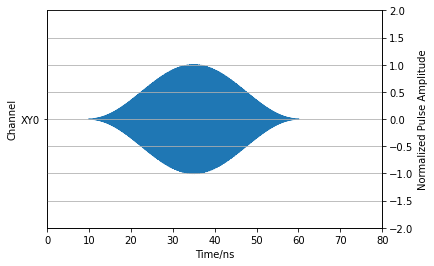

0

In [24]:
state_000, E_000, _ = _system_arb.get_eigenstates_energy((0,0,0))
state_001, E_001, _ = _system_arb.get_eigenstates_energy((0,0,1))
state_100, E_100, _ = _system_arb.get_eigenstates_energy((1,0,0))
state_101, E_101, _ = _system_arb.get_eigenstates_energy((1,0,1))
state_111, E_111, _ = _system_arb.get_eigenstates_energy((1,1,1))
state_200, E_200, _ = _system_arb.get_eigenstates_energy((2,0,0))

simulation_option = {
    "simulation_time": 80, # ns
    "simulation_step": 10000,
    "initial_state": [state_000] # Do multiple simulation
}

pulse_sequence = [
    {
        'pulse_index': 1, # [m,n] represents $\Omega_{mn}$
        'type': "XY",
        'pulse_shape': "cosine",
        't_delay': 10, # unit in ns
        't_width': 50, # unit in ns
        't_plateau': 0, # unit in ns
        'freq': (E_200 - E_000)/2, # unit in GHz; Z pulse does not use it
        'phase': 0, # unit in rad; Z pulse does not use it
        'amplitude': 0.05, # XY: Rabi freq; Z: biased frequency
        'q_index': 0 # 0, 1, 2 ...
    }
]

%matplotlib inline
## Notice that the all pulses'  amplitude are rescaled by a factor 1/1.2
pl.plot_pulse_sequence(pulse_sequence, simulation_option)

In [25]:
result_list, angle_list = _system_arb.system_dynamics_mesolve(simulation_option, pulse_sequence)

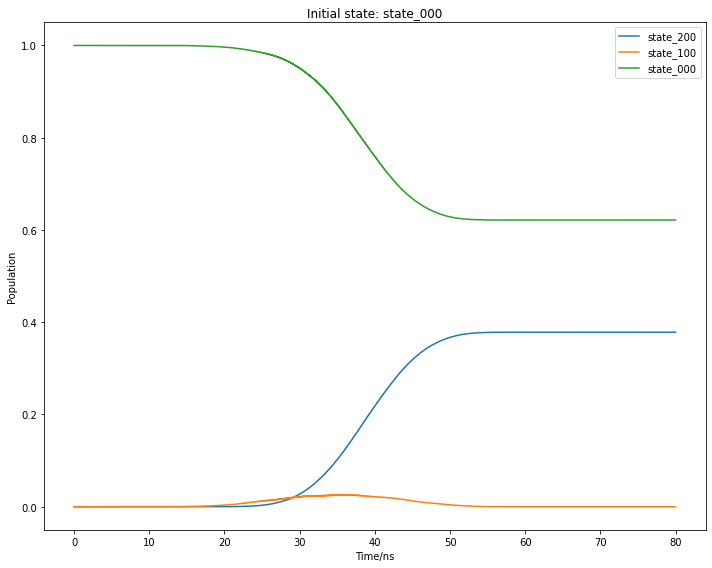

0

In [26]:
# state that you want to plot each simulation
interested_state = [
                    [state_200, state_100, state_000]
                    ]
interested_state_label = var_name2str(interested_state)
initial_state_label = var_name2str(simulation_option["initial_state"])

%matplotlib inline
# plot state population evolution
pl.plot_population_evolution(_system_arb, result_list, simulation_option, interested_state, interested_state_label, initial_state_label)

## Do system dynamic via density matrix

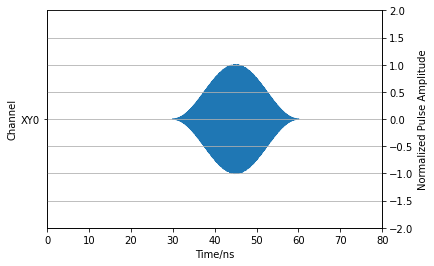

0

In [28]:
state_000, E_000, index_000 = _system_arb.get_eigenstates_energy((0,0,0))
state_010, E_010, index_010 = _system_arb.get_eigenstates_energy((0,1,0))
state_001, E_001, index_001 = _system_arb.get_eigenstates_energy((0,0,1))
state_100, E_100, index_100 = _system_arb.get_eigenstates_energy((1,0,0))
state_101, E_101, index_101 = _system_arb.get_eigenstates_energy((1,0,1))
state_111, E_111, index_111 = _system_arb.get_eigenstates_energy((1,1,1))
state_200, E_200, index_200 = _system_arb.get_eigenstates_energy((2,0,0))
state_020, E_020, index_020 = _system_arb.get_eigenstates_energy((0,2,0))

simulation_option = {
    "simulation_time": 80, # ns
    "simulation_step": 10000,
    "initial_state": [aqs.ket2dm(state_100)] # Do multiple simulation
}

pulse_sequence = [
    {
        'pulse_index': 1,
        'type': "XY",
        'pulse_shape': "cosine",
        't_delay': 30, # unit in ns
        't_width': 30, # unit in ns
        't_plateau': 0, # unit in ns
        'freq': E_100 - E_000, # unit in GHz; Z pulse does not use it
        'phase': 0, # unit in rad; Z pulse does not use it
        'amplitude': 0.2, # XY: Rabi freq; Z: biased frequency
        'q_index': 0 # 0, 1, 2 ...
    }
]

%matplotlib inline
## Notice that the all pulses'  amplitude are rescaled by a factor 1/1.2
pl.plot_pulse_sequence(pulse_sequence, simulation_option)

In [30]:
result_list, angle_list = _system_arb.system_dynamics_mesolve(simulation_option, pulse_sequence)

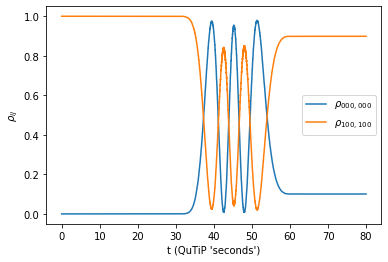

In [31]:
t = np.linspace(0, simulation_option['simulation_time'], simulation_option['simulation_step'])

# Select which result you want to see
result = result_list[0]

# Plot
%matplotlib inline

plt.plot(t,aqs.expect(result.states, state_000 * aqs.dag(state_000)), label=r'$\rho_{000,000}$');

plt.plot(t,aqs.expect(result.states, state_100 * aqs.dag(state_100)), label=r'$\rho_{100,100}$');

plt.ylabel(r"$\rho_{ij}$")
plt.xlabel("t (QuTiP 'seconds')")
plt.legend()
plt.show()

### Scan levels

In [117]:
num_level = 9 # Num of level we want to see
w2_scan_space= np.linspace(5.5, 8, 800)
energy_level_list = []

freq_list_scan = [
    [0, 6.3, 6],
    [0, 5.85, 5.58],
    [0, 6.2, 5.7]
]

for w2 in w2_scan_space:
    dummy_list = []
    freq_list_scan[1] = [0, w2, 2*w2 - 0.3]
    _system_scan = aqs.arb_qubit_system(freq_list_scan, inter_list, r, gamma_list, driving_list, bias_list)
    for j in range(0,num_level):
        dummy_list.append((_system_scan.H.eigenenergies()[j] / np.pi/2).real)
    energy_level_list.append(dummy_list)

In [119]:
%matplotlib qt
pl.plot_Elevel_dynamics(w2_scan_space, energy_level_list, 9, "\omega_c")

0

### Try iSWAP

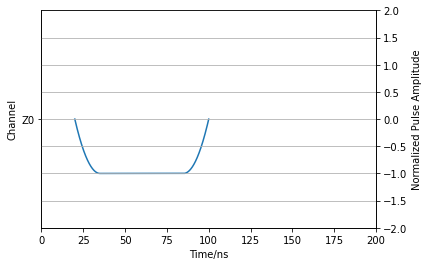

0

In [44]:
simulation_option = {
    "simulation_time": 200, # ns
    "simulation_step": 10000,
    "initial_state": [state_100] # Do multiple simulation
}

pulse_sequence = [
    {
        'pulse_index': 1, 
        'type': "Z",
        'pulse_shape': "hyper",
        't_delay': 20, # unit in ns
        't_width': 30, # unit in ns
        't_plateau': 50, # unit in ns
        'freq': 0, # unit in GHz; Z pulse does not use it
        'phase': 0, # unit in rad; Z pulse does not use it
        'amplitude': -(6.3-5.8), # XY: Rabi freq; Z: biased frequency
        'q_index': 0, # 0, 1, 2 ...
        'epsilon': 0.1
    }
]

%matplotlib inline
## Notice that the all pulses'  amplitude are rescaled by a factor 1/1.2
pl.plot_pulse_sequence(pulse_sequence, simulation_option)

In [45]:
result_list, angle_list = _system_arb.system_dynamics_mesolve(simulation_option, pulse_sequence)

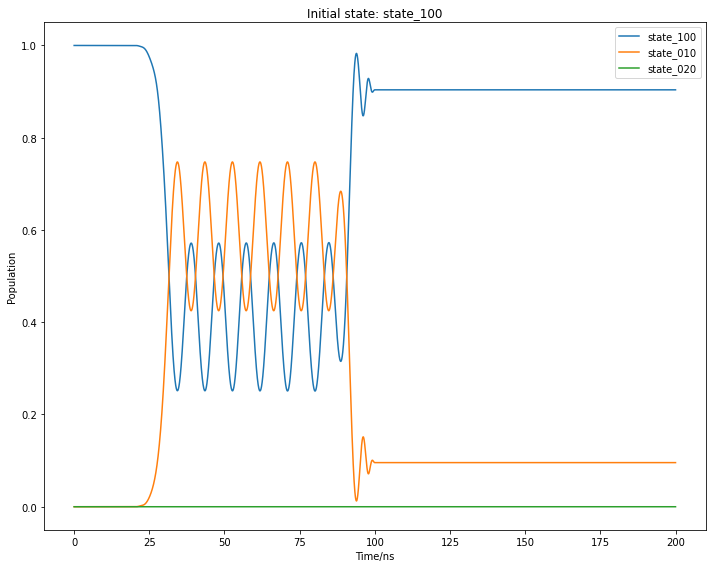

0

In [46]:
# state that you want to plot each simulation
interested_state = [
                    [state_100, state_010, state_020]
                    ]
interested_state_label = var_name2str(interested_state)
initial_state_label = var_name2str(simulation_option["initial_state"])

%matplotlib inline
# plot state population evolution
pl.plot_population_evolution(_system_arb, result_list, simulation_option, interested_state, interested_state_label, initial_state_label)

### DRAG

In [6]:
freq_list = [
    [0, 6.3, 6.3*2 - 0.3]
]

inter_list = [
    {
        "v01": 1,
        "v12": np.sqrt(2)
    }
]

r_dic = {
    "r12": 0.05,
    "r13": -0.005,
    "r23": 0.05
}
r = tools.r2matrix(r_dic, freq_list) # Coupling strength
r = 0

driving_list = [
    {
        "W01": 1,   # W01 represents \Omega_{01}, for the qubit with index 0
        "W12": np.sqrt(2)
    }
]

bias_list = [ # Default, Z00 = 0
    {
        "Z11": 1,
        "Z22": 2
    }
]

gamma_list = None

_system_arb = aqs.arb_qubit_system(freq_list, inter_list, r, gamma_list, driving_list, bias_list)

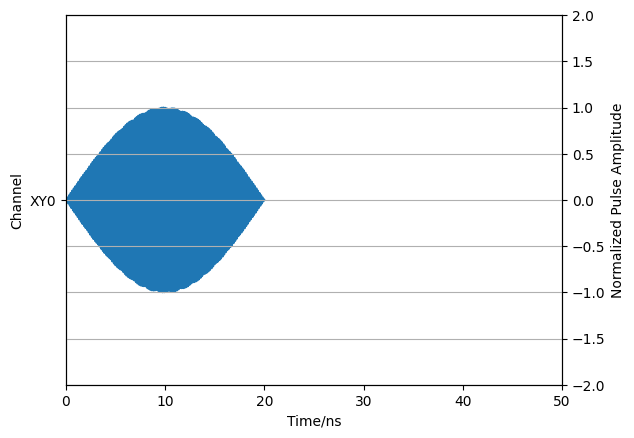

0

In [7]:
state_0, E_0, index_0 = _system_arb.get_eigenstates_energy((0,))
state_1, E_1, index_1 = _system_arb.get_eigenstates_energy((1,))

simulation_option = {
    "simulation_time": 50, # ns
    "simulation_step": 5000,
    "initial_state": [aqs.ket2dm(state_0)] # Do multiple simulation
}

pulse_sequence = [
    {
        'pulse_index': 1, # [m,n] represents $\Omega_{mn}$
        'type': "XY",
        'pulse_shape': "cosine",
        't_delay': 0, # unit in ns
        't_width': 20, # unit in ns
        't_plateau': 0, # unit in ns
        'freq': 6.3, # unit in GHz; Z pulse does not use it
        'phase': 0, # unit in rad; Z pulse does not use it
        'amplitude': 0.039292, # XY: Rabi freq; Z: biased frequency
        'q_index': 0, # 0, 1, 2 ...
        'DRAG_scale': 1,
        'DRAG_alpha': -0.3,
        'pulse_detuning': 0.001688
    }
]

%matplotlib inline
## Notice that the all pulses'  amplitude are rescaled by a factor 1/1.2
pl.plot_pulse_sequence(pulse_sequence, simulation_option)

In [8]:
result_list, angle_list = _system_arb.system_dynamics_mesolve(simulation_option, pulse_sequence)

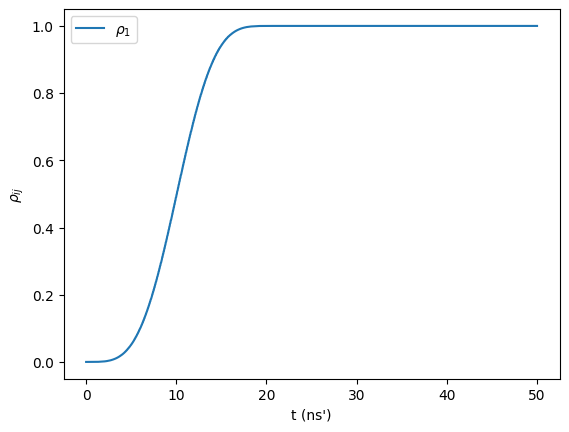

In [9]:
t = np.linspace(0, simulation_option['simulation_time'], simulation_option['simulation_step'])

# Select which result you want to see
result = result_list[0]

# Plot
%matplotlib inline

# plt.plot(t,qs.expect(result.states, state_0 * qs.dag(state_0)), label=r'$\rho_{0}$');
plt.plot(t,aqs.expect(result.states, state_1 * aqs.dag(state_1)), label=r'$\rho_{1}$');
# plt.plot(t,qs.expect(result.states, state_2 * qs.dag(state_2)), label=r'$\rho_{2}$');
plt.ylabel(r"$\rho_{ij}$")
plt.xlabel("t (ns')")
plt.legend()
plt.show()

In [10]:
aqs.expect(result.states, state_1 * aqs.dag(state_1))[4000]

0.9999266973435279

In [ ]:
for i in np.linspace(1,100,100):
    inter_list[0]['v01'] = i
    _system_arb = aqs.arb_qubit_system(freq_list, inter_list, r, gamma_list, driving_list, bias_list)